In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import zuko
from torch.optim import lr_scheduler


from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep
from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc

import h5py
import numpy as np

from datetime import datetime

# 三种网络的加载

## RESNET

In [3]:
def weight_init(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
        nn.init.constant_(m.bias.data, 0.0)

class Bottlrneck(torch.nn.Module):
    def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
        super(Bottlrneck, self).__init__()
        self.stride = 1
        if downsample == True:
            self.stride = 2
        #在这里添加BatchNorm1d和Dropout是最合适的
        self.layer = torch.nn.Sequential(
            torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
            torch.nn.BatchNorm1d(Med_channel),
            torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
            torch.nn.BatchNorm1d(Med_channel),
            #torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Out_channel, 1),
            torch.nn.BatchNorm1d(Out_channel),
            #torch.nn.ReLU(),
        )

        if In_channel != Out_channel:
            self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
        else:
            self.res_layer = None

        self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.jia_relu(self.layer(x)+residual)
    
    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.layer(x)+residual

class ResNet(torch.nn.Module):
    def __init__(self,in_channels=1,classes=5):
        super(ResNet, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
            torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

            Bottlrneck(64,64,256,False),
            Bottlrneck(256,64,256,False),
            Bottlrneck(256,64,256,False),#256*x/4*x/4



            Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),



            Bottlrneck(512,256,1024, True),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),



            Bottlrneck(1024,512,2048, True),
            Bottlrneck(2048,512,2048, False),
            Bottlrneck(2048,512,2048, False),

            torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(2048,classes)#变成每类特征的信息
        )
        

    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,2048)
        x = self.classifer(x)
        return x

model=torch.load(f'/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens_res_can_all.pth')
model.eval();

In [4]:
#重置网络参数，方便for循环调参
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)

class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(2, 128) 
        self.norm1 = nn.LayerNorm(128)
        
        self.layer2 = nn.Linear(128, 128)
        self.norm2 = nn.LayerNorm(128)

        self.layer3 = nn.Linear(128, 128)
        self.norm3 = nn.LayerNorm(128)
        
        self.layer4 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(p=0.2)
        #self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.layer1(x)) 
        #x = self.dropout(x)
        x = self.norm1(x)
        
        x = self.relu(self.layer2(x))
        #x = self.dropout(x)
        x = self.norm2(x)
        
        x = self.relu(self.layer3(x))
        #x = self.dropout(x)
        x = self.norm3(x)
        
        x = self.layer4(x)
        return x

In [5]:
estimator=torch.load(f'/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens_res_can_hou.pth')
estimator.eval();

## NPE

In [6]:
#  "act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0.001,休眠率0.2,参数数目1024,参数层数7,流层9,中间层256,最佳损失-5.820067882537842,训练周期28",
#"act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0,休眠率0.2,参数数目1024,参数层数7,流层9,中间层512,最佳损失-3.325531482696533,训练周期35",
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def fix_bn(m):
                classname = m.__class__.__name__
                if classname.find('BatchNorm') != -1:
                    m.eval()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

            class NPEWithEmbedding(nn.Module):#这个网络只要是1维的2的倍数就行
                def __init__(self,channels=3,beishu=4,canshu=2,build=zuko.flows.NSF,hidden_features=[128] * 3,activation=nn.ELU,transforms=3):
                    super().__init__()

                    self.npe = NPE(canshu, beishu, build=build, hidden_features=hidden_features,transforms=transforms, activation=activation)#用于
                    self.embedding = ResNet(in_channels=channels,classes=beishu)

                def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
                    #print(self.embedding(x).shape)

                    return self.npe(theta, self.embedding(x))

                def flow(self, x: torch.Tensor):  # -> flow对应原来的采样，因为他调用的就是flow
                    return self.npe.flow(self.embedding(x))
                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            
            estimator_NPE= NPEWithEmbedding(channels=4,canshu=2,beishu=beishu,build=liu,hidden_features=[num] * transfomr,transforms=trans,activation=act).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            estimator_NPE.apply(weight_init);
            estimator_NPE.load_state_dict(torch.load("/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens.pth"))
            loss = NPELoss(estimator_NPE);
            estimator_NPE.cuda();
            estimator_NPE.train();
            estimator_NPE.apply(fix_bn) 
            estimator_NPE.eval();

In [7]:
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x

                    return self.jia_relu(self.layer(x)+residual)

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),;
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

In [8]:
model_NPE=torch.load(f'/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens_ce_all.pth')

## 直接

In [9]:
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x



                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            model_y= ResNet(in_channels=4,classes=1).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            model_y.apply(weight_init)
            
            optimizer = optim.AdamW(model_y.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            loss = nn.BCEWithLogitsLoss()

            list_los=[]
            list_losvail=[]

In [10]:
model_y=torch.load(f'/home/DATA/suntianyang/gw_len/net/net/NPE_mid_t_lens_yyy_all.pth')

# 预测的ROC

In [13]:
from sklearn.metrics import roc_curve, auc
import gc

## RES

In [14]:
def get_wave_plus_gaosnoise_t_gen_cai(data):
    samples_all=torch.zeros((data.shape[0],2))
    for i in range(data.shape[0]):
        model.eval()
        with torch.no_grad():
            samples = model(data[i].unsqueeze(0).cuda()).cpu()

        samples_all[i,0]=samples[0,0]
        samples_all[i,1]=samples[0,1]
            
    return samples_all

In [15]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_data_y_roc_PM_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_label_roc_PM_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(x).reshape(-1,2)
    all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        estimator.eval()
        with torch.no_grad():
            #print(all_x_vail[i].dtype)
            y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/GW_lens/ROC/RES_y_PM_{SNR}',y)
    np.save(f'/home/suntianyang/GW_lens/ROC/RES_p_PM_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

/tmp/ipykernel_231877/2744270405.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)


In [16]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_data_y_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_label_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(x).reshape(-1,2)
    all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        estimator.eval()
        with torch.no_grad():
            #print(all_x_vail[i].dtype)
            y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
        y_pre_all.append(float(y_pre))
    
    np.save(f'/home/suntianyang/GW_lens/ROC/RES_y_SIS_{SNR}',y)
    np.save(f'/home/suntianyang/GW_lens/ROC/RES_p_SIS_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

/tmp/ipykernel_231877/3398887801.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)


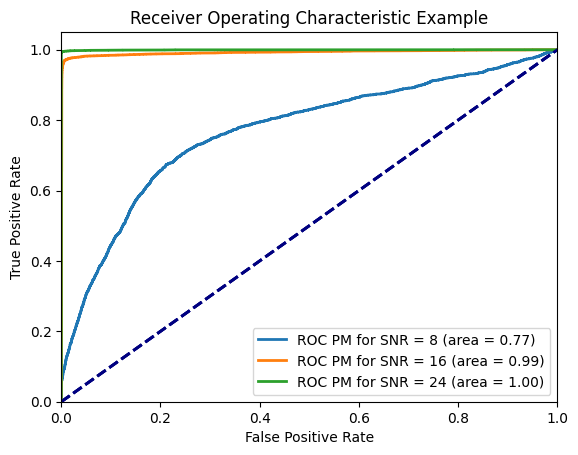

In [17]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/GW_lens/ROC/RES_y_PM_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/GW_lens/ROC/RES_p_PM_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    
    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

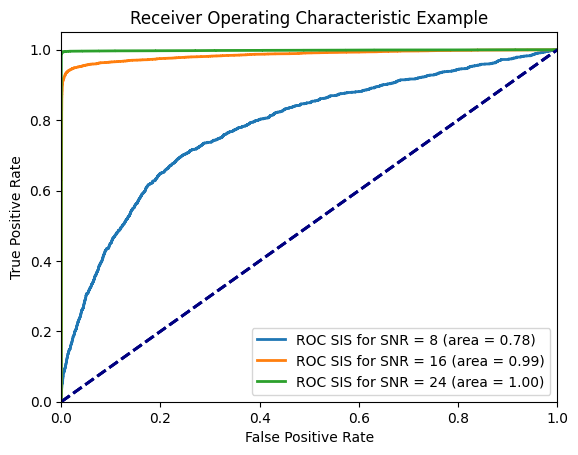

In [18]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/GW_lens/ROC/RES_y_SIS_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/GW_lens/ROC/RES_p_SIS_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    
    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC SIS for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)

plt.show()

## NPE

In [36]:
#固定的参数

LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER


def get_wave_plus_gaosnoise_t_gen_cai_NPE(data):
    nnnyyu=2**5
    samples_all=torch.zeros((data.shape[0],2,nnnyyu))
    for i in range(data.shape[0]):
        estimator_NPE.eval()
        with torch.no_grad():
            samples = estimator_NPE.flow(data[i].reshape(1,4,40960).cuda()).sample((nnnyyu,)).cpu()
            samples = postprocess(samples)
            
        samples_all[i,0,:]=samples[:,0,0]
        samples_all[i,1,:]=samples[:,0,1]
    return samples_all

In [23]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_data_y_roc_PM_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_label_roc_PM_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(x).reshape(-1,2,2**5)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        model_NPE.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/GW_lens/ROC/NPE_y_PM_{SNR}',y)
    np.save(f'/home/suntianyang/GW_lens/ROC/NPE_p_PM_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

In [37]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_data_y_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_label_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(x).reshape(-1,2,2**5)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        model_NPE.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/GW_lens/ROC/NPE_y_SIS_{SNR}',y)
    np.save(f'/home/suntianyang/GW_lens/ROC/NPE_p_SIS_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

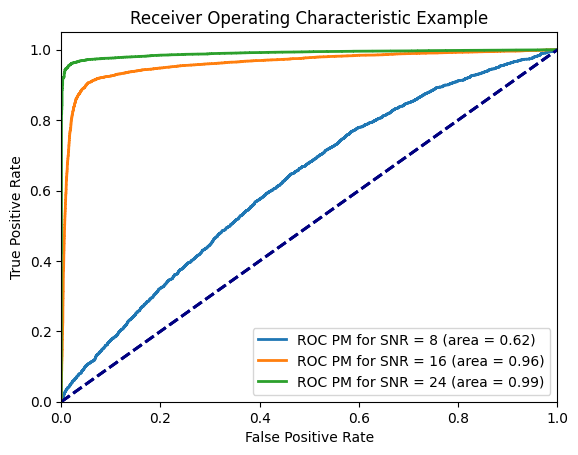

In [30]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/GW_lens/ROC/NPE_y_PM_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/GW_lens/ROC/NPE_p_PM_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    
    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

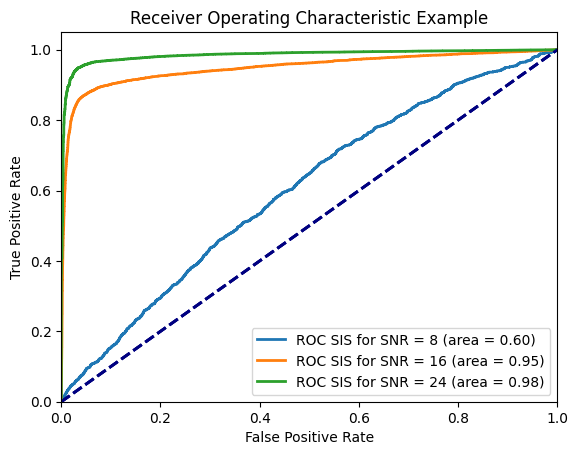

In [46]:
plt.figure()

for SNR in [8,16,24]:
    # 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/GW_lens/ROC/NPE_y_SIS_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/GW_lens/ROC/NPE_p_SIS_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    
    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC SIS for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

## 直接

In [19]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_data_y_roc_PM_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_label_roc_PM_{SNR}.npy'),dtype=torch.float32)
    
    y_pre_all=[]
    for i in range(x.shape[0]):
        model_y.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_y(x[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/GW_lens/ROC/test/P_y_PM_{SNR}',y)
    np.save(f'/home/suntianyang/GW_lens/ROC/test/P_p_PM_{SNR}',y_pre_all)
    
    del x,y,y_pre_all

In [20]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_data_y_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/DATA/suntianyang/gw_len/data/ROC/test_label_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    
    y_pre_all=[]
    for i in range(x.shape[0]):
        model_y.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_y(x[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/GW_lens/ROC/test/P_y_SIS_{SNR}',y)
    np.save(f'/home/suntianyang/GW_lens/ROC/test/P_p_SIS_{SNR}',y_pre_all)
    
    del x,y,y_pre_all

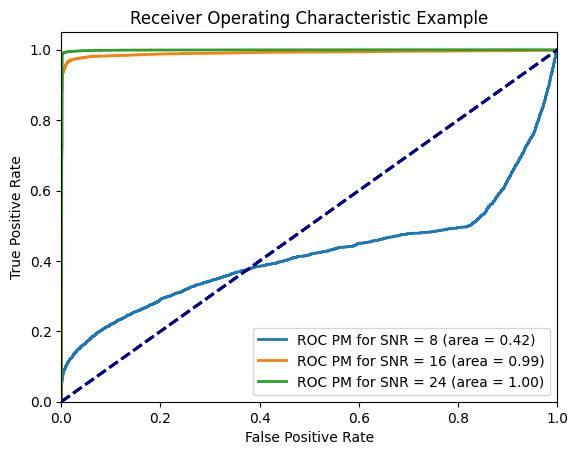

In [21]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/GW_lens/ROC/test/P_y_PM_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/GW_lens/ROC/test/P_p_PM_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    
    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

In [ ]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/GW_lens/ROC/test/P_y_SIS_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/GW_lens/ROC/test/P_p_SIS_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    
    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC SIS for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()